<a href="https://colab.research.google.com/github/AnnPike/Portfolio/blob/master/ResNet10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Experiment: constructing small(10 layers) ResNet with different numbers of layers in a block. The first layer is convolutions 4by4 with stride 2, then 8 blocks of convolutions 3by3 with increasing depth(16,16,32,32,32,64,64,64) and then average pooling layer and softmax. ResNet10_35 means that we add identity after the third and the fifth layers of convolulutions 3by3. The architecture resembles classical ResNets. The data is CIFAR10 and the task of a NN is recognition. My goal is to figure out how length of blocks influence the performance of a ResNet.

# Load data and libraries

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
import torch
import numpy as np
import time

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = 250
valid_size = 0.2
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (1,1,1))])

train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

num_train = len(train_data)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cuda:0


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


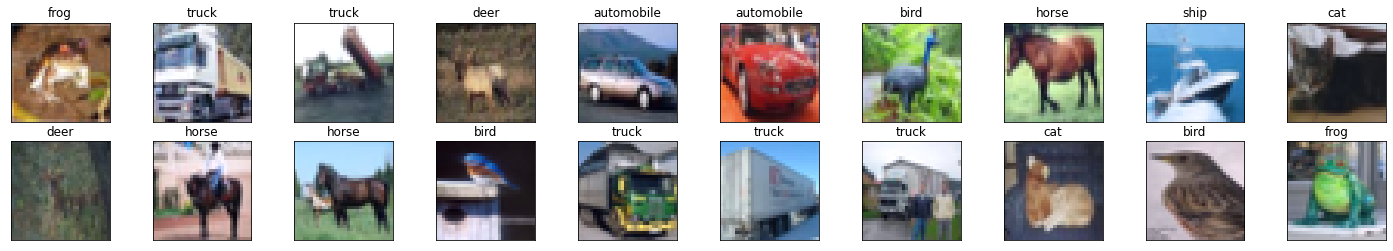

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
  img = img + 0.5
  plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
# obtain one batch of training images
images, labels = iter(torch.utils.data.DataLoader(train_data, batch_size=20)).next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## Training function

I used early stopping with patience 2 for training each ResNet and patience 5 for Plain one since it needed some time to start converging.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
num_epochs = 100
patience = 2

def train_model(model, batch_size, patience, num_epochs, model_name):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, num_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(num_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))
    model_save_name = model_name+'.pt'
    path = F"/content/gdrive/My Drive/ResNet10_momentum0.9_patience2avpool22/{model_save_name}" 
    torch.save(model.state_dict(), path)

    return  model, avg_train_losses, avg_valid_losses, epoch

## Testing function

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

def eval_model(model):
  test_loss = 0.0
  PREDICT = torch.empty(0).to(device)
  CORRECT = torch.empty(0).to(device)
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()
    _, pred = torch.max(output,1)
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    PREDICT = torch.cat([PREDICT,pred],axis=0)
    CORRECT = torch.cat([CORRECT,target],axis=0)
  test_loss = test_loss/len(test_loader)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  cf_matrix = confusion_matrix(CORRECT.cpu(), PREDICT.cpu())
  cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
  sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues', xticklabels=classes)
  plt.title('confusuin matrix for test predictions in percent')
  plt.show()

  print(classification_report(CORRECT.cpu(), PREDICT.cpu(), target_names=classes, digits=4))
  return accuracy_score(CORRECT.cpu(), PREDICT.cpu())

In [ ]:
def plot_losses(train, valid, e):
  plt.plot(range(1,e+1),train,'y',label = 'train loss')
  plt.plot(range(1,e+1),valid,'b', label = 'valid_loss')
  plt.legend()
  plt.show()

In [1]:
import pickle
train_loss_dict = {}
valid_loss_dict = {}
test_accuracy_dict = {}

# ResNet10_8

In [ ]:
model_name = 'ResNet10_8'
class ResNet10_8(nn.Module):
  def __init__(self):
    super(ResNet10_8,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_48 = torch.zeros(batch_size,48,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_48],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_8()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 2.02540 valid_loss: 1.83025
Validation loss decreased (inf --> 1.830252).  Saving model ...
[  2/100] train_loss: 1.77225 valid_loss: 1.73669
Validation loss decreased (1.830252 --> 1.736691).  Saving model ...
[  3/100] train_loss: 1.69346 valid_loss: 1.68067
Validation loss decreased (1.736691 --> 1.680671).  Saving model ...
[  4/100] train_loss: 1.63645 valid_loss: 1.61582
Validation loss decreased (1.680671 --> 1.615823).  Saving model ...
[  5/100] train_loss: 1.57359 valid_loss: 1.54795
Validation loss decreased (1.615823 --> 1.547946).  Saving model ...
[  6/100] train_loss: 1.51788 valid_loss: 1.50795
Validation loss decreased (1.547946 --> 1.507945).  Saving model ...
[  7/100] train_loss: 1.47357 valid_loss: 1.47212
Validation loss decreased (1.507945 --> 1.472120).  Saving model ...
[  8/100] train_loss: 1.44358 valid_loss: 1.44542
Validation loss decreased (1.472120 --> 1.445422).  Saving model ...
[  9/100] train_loss: 1.42164 valid_loss: 1.42200
Val

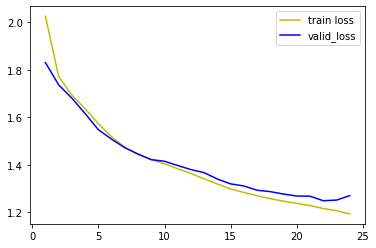

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 1.252425



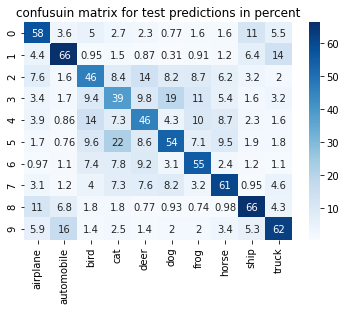

              precision    recall  f1-score   support

    airplane     0.5767    0.6540    0.6129      1000
  automobile     0.6619    0.6950    0.6780      1000
        bird     0.4632    0.3900    0.4235      1000
         cat     0.3858    0.4120    0.3985      1000
        deer     0.4579    0.4730    0.4653      1000
         dog     0.5355    0.3470    0.4211      1000
        frog     0.5514    0.6700    0.6050      1000
       horse     0.6067    0.6170    0.6118      1000
        ship     0.6559    0.6920    0.6735      1000
       truck     0.6215    0.5830    0.6017      1000

    accuracy                         0.5533     10000
   macro avg     0.5517    0.5533    0.5491     10000
weighted avg     0.5517    0.5533    0.5491     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_44

In [ ]:
model_name = 'ResNet10_44'
class ResNet10_44(nn.Module):
  def __init__(self):
    super(ResNet10_44,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_44()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 2.00740 valid_loss: 1.79197
Validation loss decreased (inf --> 1.791973).  Saving model ...
[  2/100] train_loss: 1.69778 valid_loss: 1.64199
Validation loss decreased (1.791973 --> 1.641990).  Saving model ...
[  3/100] train_loss: 1.55355 valid_loss: 1.49394
Validation loss decreased (1.641990 --> 1.493939).  Saving model ...
[  4/100] train_loss: 1.45740 valid_loss: 1.42016
Validation loss decreased (1.493939 --> 1.420155).  Saving model ...
[  5/100] train_loss: 1.37009 valid_loss: 1.38239
Validation loss decreased (1.420155 --> 1.382392).  Saving model ...
[  6/100] train_loss: 1.29430 valid_loss: 1.29523
Validation loss decreased (1.382392 --> 1.295231).  Saving model ...
[  7/100] train_loss: 1.25209 valid_loss: 1.22602
Validation loss decreased (1.295231 --> 1.226021).  Saving model ...
[  8/100] train_loss: 1.20096 valid_loss: 1.19251
Validation loss decreased (1.226021 --> 1.192512).  Saving model ...
[  9/100] train_loss: 1.15145 valid_loss: 1.16119
Val

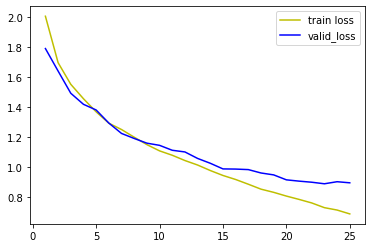

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.901364



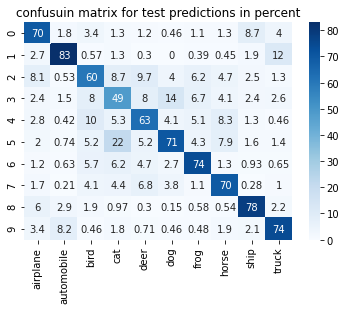

              precision    recall  f1-score   support

    airplane     0.6972    0.7620    0.7281      1000
  automobile     0.8307    0.7900    0.8098      1000
        bird     0.6032    0.5290    0.5637      1000
         cat     0.4851    0.5520    0.5164      1000
        deer     0.6316    0.6240    0.6278      1000
         dog     0.7067    0.4650    0.5609      1000
        frog     0.7413    0.7650    0.7530      1000
       horse     0.6966    0.7760    0.7342      1000
        ship     0.7824    0.8380    0.8093      1000
       truck     0.7440    0.8020    0.7719      1000

    accuracy                         0.6903     10000
   macro avg     0.6919    0.6903    0.6875     10000
weighted avg     0.6919    0.6903    0.6875     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_332

In [ ]:
model_name = 'ResNet10_332'
class ResNet10_332(nn.Module):
  def __init__(self):
    super(ResNet10_332,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    identity = x.clone()
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_332()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 1.98492 valid_loss: 1.75428
Validation loss decreased (inf --> 1.754283).  Saving model ...
[  2/100] train_loss: 1.65953 valid_loss: 1.56929
Validation loss decreased (1.754283 --> 1.569285).  Saving model ...
[  3/100] train_loss: 1.50235 valid_loss: 1.44837
Validation loss decreased (1.569285 --> 1.448368).  Saving model ...
[  4/100] train_loss: 1.37894 valid_loss: 1.31796
Validation loss decreased (1.448368 --> 1.317962).  Saving model ...
[  5/100] train_loss: 1.29476 valid_loss: 1.27586
Validation loss decreased (1.317962 --> 1.275861).  Saving model ...
[  6/100] train_loss: 1.23122 valid_loss: 1.21892
Validation loss decreased (1.275861 --> 1.218919).  Saving model ...
[  7/100] train_loss: 1.17779 valid_loss: 1.19645
Validation loss decreased (1.218919 --> 1.196448).  Saving model ...
[  8/100] train_loss: 1.12070 valid_loss: 1.13591
Validation loss decreased (1.196448 --> 1.135915).  Saving model ...
[  9/100] train_loss: 1.07902 valid_loss: 1.09195
Val

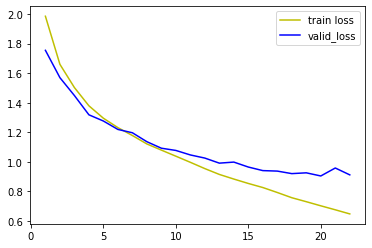

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.890018



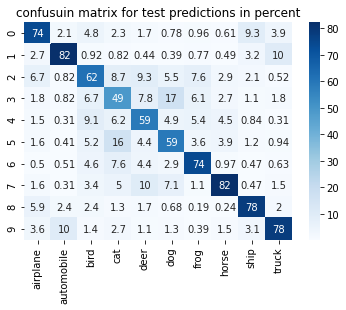

              precision    recall  f1-score   support

    airplane     0.7407    0.7340    0.7373      1000
  automobile     0.8209    0.8020    0.8113      1000
        bird     0.6158    0.5370    0.5737      1000
         cat     0.4899    0.5360    0.5119      1000
        deer     0.5915    0.6790    0.6322      1000
         dog     0.5940    0.6130    0.6033      1000
        frog     0.7399    0.7680    0.7537      1000
       horse     0.8228    0.6780    0.7434      1000
        ship     0.7826    0.8350    0.8079      1000
       truck     0.7816    0.7480    0.7644      1000

    accuracy                         0.6930     10000
   macro avg     0.6980    0.6930    0.6939     10000
weighted avg     0.6980    0.6930    0.6939     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_323

In [ ]:
model_name = 'ResNet10_323'
class ResNet10_323(nn.Module):
  def __init__(self):
    super(ResNet10_323,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(x + identity)
    identity = x.clone()
    x = F.relu(self.conv3_1(x)) #layer7 64*16    
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_323()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 1.96207 valid_loss: 1.75429
Validation loss decreased (inf --> 1.754295).  Saving model ...
[  2/100] train_loss: 1.66113 valid_loss: 1.56428
Validation loss decreased (1.754295 --> 1.564279).  Saving model ...
[  3/100] train_loss: 1.51815 valid_loss: 1.45656
Validation loss decreased (1.564279 --> 1.456558).  Saving model ...
[  4/100] train_loss: 1.41735 valid_loss: 1.36639
Validation loss decreased (1.456558 --> 1.366393).  Saving model ...
[  5/100] train_loss: 1.32661 valid_loss: 1.26663
Validation loss decreased (1.366393 --> 1.266628).  Saving model ...
[  6/100] train_loss: 1.23878 valid_loss: 1.21473
Validation loss decreased (1.266628 --> 1.214735).  Saving model ...
[  7/100] train_loss: 1.17721 valid_loss: 1.16764
Validation loss decreased (1.214735 --> 1.167639).  Saving model ...
[  8/100] train_loss: 1.12741 valid_loss: 1.14049
Validation loss decreased (1.167639 --> 1.140485).  Saving model ...
[  9/100] train_loss: 1.07777 valid_loss: 1.14781
Ear

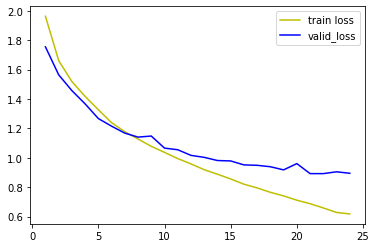

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.900515



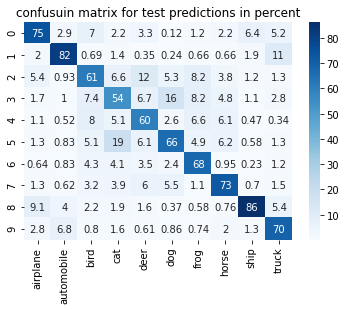

              precision    recall  f1-score   support

    airplane     0.7471    0.6970    0.7212      1000
  automobile     0.8151    0.7890    0.8018      1000
        bird     0.6138    0.5340    0.5711      1000
         cat     0.5416    0.5080    0.5243      1000
        deer     0.6009    0.6940    0.6441      1000
         dog     0.6634    0.5420    0.5966      1000
        frog     0.6793    0.8240    0.7447      1000
       horse     0.7261    0.7660    0.7455      1000
        ship     0.8623    0.7390    0.7959      1000
       truck     0.6960    0.8310    0.7575      1000

    accuracy                         0.6924     10000
   macro avg     0.6945    0.6924    0.6903     10000
weighted avg     0.6945    0.6924    0.6903     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_233

In [ ]:
model_name = 'ResNet10_233'
class ResNet10_233(nn.Module):
  def __init__(self):
    super(ResNet10_233,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone()
    x = F.relu(self.conv2_1(x)) #layer4 32*16*1
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv3_1(x)) #layer7 64*16    
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_233()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 1.98114 valid_loss: 1.74026
Validation loss decreased (inf --> 1.740261).  Saving model ...
[  2/100] train_loss: 1.65383 valid_loss: 1.59227
Validation loss decreased (1.740261 --> 1.592271).  Saving model ...
[  3/100] train_loss: 1.50701 valid_loss: 1.41637
Validation loss decreased (1.592271 --> 1.416370).  Saving model ...
[  4/100] train_loss: 1.38022 valid_loss: 1.35272
Validation loss decreased (1.416370 --> 1.352722).  Saving model ...
[  5/100] train_loss: 1.29211 valid_loss: 1.25844
Validation loss decreased (1.352722 --> 1.258442).  Saving model ...
[  6/100] train_loss: 1.23324 valid_loss: 1.20497
Validation loss decreased (1.258442 --> 1.204966).  Saving model ...
[  7/100] train_loss: 1.17809 valid_loss: 1.16460
Validation loss decreased (1.204966 --> 1.164598).  Saving model ...
[  8/100] train_loss: 1.12648 valid_loss: 1.11857
Validation loss decreased (1.164598 --> 1.118572).  Saving model ...
[  9/100] train_loss: 1.09019 valid_loss: 1.10662
Val

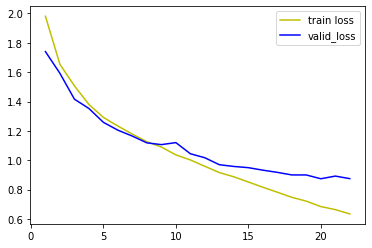

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.880889



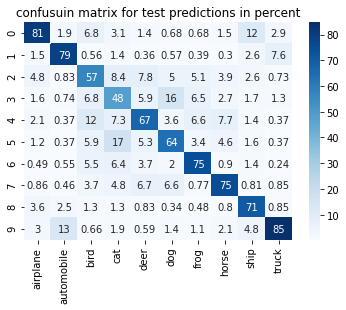

              precision    recall  f1-score   support

    airplane     0.8089    0.6560    0.7245      1000
  automobile     0.7911    0.8560    0.8223      1000
        bird     0.5718    0.6090    0.5898      1000
         cat     0.4837    0.5940    0.5332      1000
        deer     0.6734    0.5670    0.6156      1000
         dog     0.6416    0.5640    0.6003      1000
        frog     0.7505    0.7760    0.7630      1000
       horse     0.7540    0.7510    0.7525      1000
        ship     0.7118    0.8840    0.7886      1000
       truck     0.8477    0.6960    0.7644      1000

    accuracy                         0.6953     10000
   macro avg     0.7035    0.6953    0.6954     10000
weighted avg     0.7035    0.6953    0.6954     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_2222

In [ ]:
model_name = 'ResNet10_2222'
class ResNet10_2222(nn.Module):
  def __init__(self):
    super(ResNet10_2222,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone() 
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    identity = x.clone()
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_2222()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 1.97018 valid_loss: 1.73525
Validation loss decreased (inf --> 1.735250).  Saving model ...
[  2/100] train_loss: 1.64750 valid_loss: 1.60300
Validation loss decreased (1.735250 --> 1.603002).  Saving model ...
[  3/100] train_loss: 1.48164 valid_loss: 1.44236
Validation loss decreased (1.603002 --> 1.442362).  Saving model ...
[  4/100] train_loss: 1.36995 valid_loss: 1.29532
Validation loss decreased (1.442362 --> 1.295323).  Saving model ...
[  5/100] train_loss: 1.27022 valid_loss: 1.24817
Validation loss decreased (1.295323 --> 1.248167).  Saving model ...
[  6/100] train_loss: 1.21679 valid_loss: 1.20096
Validation loss decreased (1.248167 --> 1.200955).  Saving model ...
[  7/100] train_loss: 1.14894 valid_loss: 1.14752
Validation loss decreased (1.200955 --> 1.147518).  Saving model ...
[  8/100] train_loss: 1.08816 valid_loss: 1.11731
Validation loss decreased (1.147518 --> 1.117308).  Saving model ...
[  9/100] train_loss: 1.04273 valid_loss: 1.09389
Val

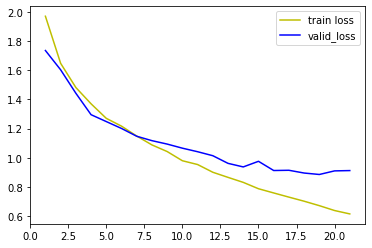

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.888926



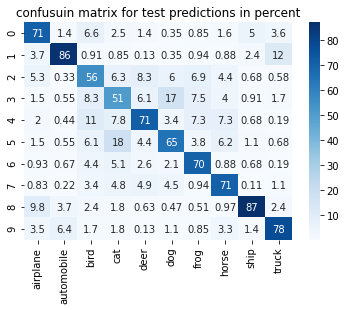

              precision    recall  f1-score   support

    airplane     0.7090    0.7650    0.7359      1000
  automobile     0.8570    0.7730    0.8128      1000
        bird     0.5563    0.6130    0.5833      1000
         cat     0.5071    0.5360    0.5211      1000
        deer     0.7139    0.5690    0.6333      1000
         dog     0.6482    0.5510    0.5957      1000
        frog     0.7039    0.8250    0.7597      1000
       horse     0.7051    0.8010    0.7500      1000
        ship     0.8703    0.7650    0.8143      1000
       truck     0.7768    0.7970    0.7868      1000

    accuracy                         0.6995     10000
   macro avg     0.7048    0.6995    0.6993     10000
weighted avg     0.7048    0.6995    0.6993     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_224

In [ ]:
model_name = 'ResNet10_224'
class ResNet10_224(nn.Module):
  def __init__(self):
    super(ResNet10_224,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone() 
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_224()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 1.96585 valid_loss: 1.75100
Validation loss decreased (inf --> 1.750997).  Saving model ...
[  2/100] train_loss: 1.64763 valid_loss: 1.59263
Validation loss decreased (1.750997 --> 1.592626).  Saving model ...
[  3/100] train_loss: 1.48250 valid_loss: 1.41366
Validation loss decreased (1.592626 --> 1.413663).  Saving model ...
[  4/100] train_loss: 1.35527 valid_loss: 1.36799
Validation loss decreased (1.413663 --> 1.367992).  Saving model ...
[  5/100] train_loss: 1.28584 valid_loss: 1.29958
Validation loss decreased (1.367992 --> 1.299579).  Saving model ...
[  6/100] train_loss: 1.20830 valid_loss: 1.20692
Validation loss decreased (1.299579 --> 1.206924).  Saving model ...
[  7/100] train_loss: 1.16236 valid_loss: 1.14416
Validation loss decreased (1.206924 --> 1.144161).  Saving model ...
[  8/100] train_loss: 1.11572 valid_loss: 1.12557
Validation loss decreased (1.144161 --> 1.125569).  Saving model ...
[  9/100] train_loss: 1.07288 valid_loss: 1.10372
Val

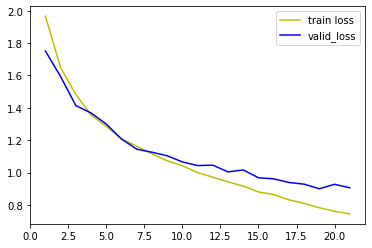

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.902283



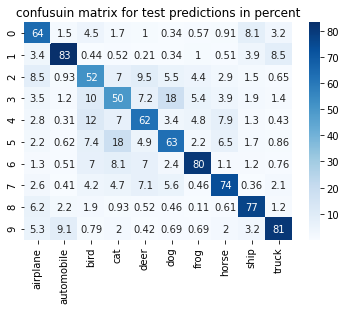

              precision    recall  f1-score   support

    airplane     0.6425    0.7710    0.7009      1000
  automobile     0.8321    0.8080    0.8199      1000
        bird     0.5179    0.5930    0.5529      1000
         cat     0.4979    0.4800    0.4888      1000
        deer     0.6215    0.5960    0.6085      1000
         dog     0.6292    0.5480    0.5858      1000
        frog     0.8041    0.7020    0.7496      1000
       horse     0.7361    0.7280    0.7320      1000
        ship     0.7686    0.8470    0.8059      1000
       truck     0.8089    0.7490    0.7778      1000

    accuracy                         0.6822     10000
   macro avg     0.6859    0.6822    0.6822     10000
weighted avg     0.6859    0.6822    0.6822     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_422

In [ ]:
model_name = 'ResNet10_422'
class ResNet10_422(nn.Module):
  def __init__(self):
    super(ResNet10_422,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    identity = x.clone()
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_422()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 1.97813 valid_loss: 1.76208
Validation loss decreased (inf --> 1.762084).  Saving model ...
[  2/100] train_loss: 1.65817 valid_loss: 1.54580
Validation loss decreased (1.762084 --> 1.545800).  Saving model ...
[  3/100] train_loss: 1.48591 valid_loss: 1.43668
Validation loss decreased (1.545800 --> 1.436679).  Saving model ...
[  4/100] train_loss: 1.35648 valid_loss: 1.31558
Validation loss decreased (1.436679 --> 1.315583).  Saving model ...
[  5/100] train_loss: 1.26285 valid_loss: 1.22794
Validation loss decreased (1.315583 --> 1.227944).  Saving model ...
[  6/100] train_loss: 1.19477 valid_loss: 1.18998
Validation loss decreased (1.227944 --> 1.189976).  Saving model ...
[  7/100] train_loss: 1.13010 valid_loss: 1.13915
Validation loss decreased (1.189976 --> 1.139149).  Saving model ...
[  8/100] train_loss: 1.07885 valid_loss: 1.09991
Validation loss decreased (1.139149 --> 1.099909).  Saving model ...
[  9/100] train_loss: 1.02799 valid_loss: 1.07641
Val

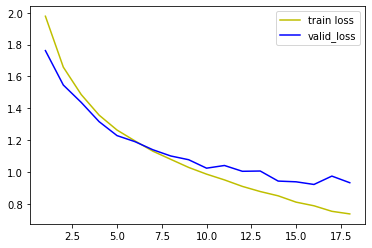

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.919525



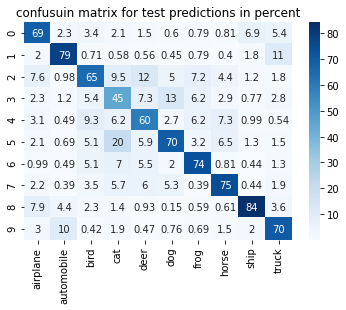

              precision    recall  f1-score   support

    airplane     0.6879    0.7650    0.7244      1000
  automobile     0.7892    0.8050    0.7970      1000
        bird     0.6488    0.4600    0.5383      1000
         cat     0.4524    0.6270    0.5256      1000
        deer     0.5953    0.6400    0.6169      1000
         dog     0.6979    0.4620    0.5560      1000
        frog     0.7397    0.7530    0.7463      1000
       horse     0.7472    0.7390    0.7431      1000
        ship     0.8423    0.7690    0.8040      1000
       truck     0.7025    0.7840    0.7410      1000

    accuracy                         0.6804     10000
   macro avg     0.6903    0.6804    0.6793     10000
weighted avg     0.6903    0.6804    0.6793     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_242

In [ ]:
model_name = 'ResNet10_242'
class ResNet10_242(nn.Module):
  def __init__(self):
    super(ResNet10_242,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_48 = torch.zeros(batch_size,48,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone() 
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_48],axis=1))
    identity = x.clone()
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_242()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 1.94115 valid_loss: 1.73570
Validation loss decreased (inf --> 1.735696).  Saving model ...
[  2/100] train_loss: 1.66622 valid_loss: 1.60059
Validation loss decreased (1.735696 --> 1.600590).  Saving model ...
[  3/100] train_loss: 1.55905 valid_loss: 1.54507
Validation loss decreased (1.600590 --> 1.545070).  Saving model ...
[  4/100] train_loss: 1.47353 valid_loss: 1.43018
Validation loss decreased (1.545070 --> 1.430177).  Saving model ...
[  5/100] train_loss: 1.38729 valid_loss: 1.37945
Validation loss decreased (1.430177 --> 1.379450).  Saving model ...
[  6/100] train_loss: 1.31979 valid_loss: 1.28879
Validation loss decreased (1.379450 --> 1.288788).  Saving model ...
[  7/100] train_loss: 1.24619 valid_loss: 1.23419
Validation loss decreased (1.288788 --> 1.234186).  Saving model ...
[  8/100] train_loss: 1.19688 valid_loss: 1.17526
Validation loss decreased (1.234186 --> 1.175261).  Saving model ...
[  9/100] train_loss: 1.14153 valid_loss: 1.17691
Ear

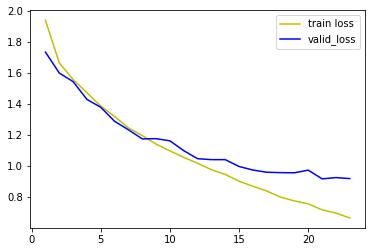

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.929641



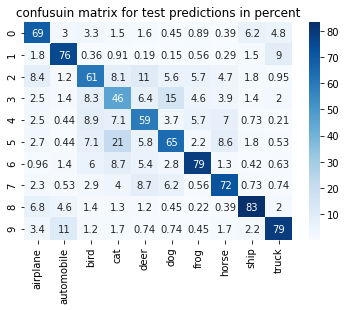

              precision    recall  f1-score   support

    airplane     0.6851    0.7810    0.7299      1000
  automobile     0.7584    0.8540    0.8034      1000
        bird     0.6065    0.5070    0.5523      1000
         cat     0.4567    0.6010    0.5190      1000
        deer     0.5939    0.6420    0.6170      1000
         dog     0.6454    0.4350    0.5197      1000
        frog     0.7911    0.7080    0.7472      1000
       horse     0.7183    0.7370    0.7275      1000
        ship     0.8335    0.8010    0.8169      1000
       truck     0.7915    0.7480    0.7692      1000

    accuracy                         0.6814     10000
   macro avg     0.6880    0.6814    0.6802     10000
weighted avg     0.6880    0.6814    0.6802     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_62

In [ ]:
model_name = 'ResNet10_62'
class ResNet10_62(nn.Module):
  def __init__(self):
    super(ResNet10_62,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_48 = torch.zeros(batch_size,48,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16 
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16
    x = F.relu(x + torch.cat([identity,padding_zeros_48],axis=1))
    identity = x.clone()
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + identity)
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_62()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 2.00952 valid_loss: 1.78098
Validation loss decreased (inf --> 1.780978).  Saving model ...
[  2/100] train_loss: 1.70514 valid_loss: 1.67268
Validation loss decreased (1.780978 --> 1.672683).  Saving model ...
[  3/100] train_loss: 1.56885 valid_loss: 1.51232
Validation loss decreased (1.672683 --> 1.512318).  Saving model ...
[  4/100] train_loss: 1.44819 valid_loss: 1.40453
Validation loss decreased (1.512318 --> 1.404532).  Saving model ...
[  5/100] train_loss: 1.35413 valid_loss: 1.31587
Validation loss decreased (1.404532 --> 1.315866).  Saving model ...
[  6/100] train_loss: 1.28584 valid_loss: 1.30228
Validation loss decreased (1.315866 --> 1.302281).  Saving model ...
[  7/100] train_loss: 1.24358 valid_loss: 1.22527
Validation loss decreased (1.302281 --> 1.225267).  Saving model ...
[  8/100] train_loss: 1.19377 valid_loss: 1.20101
Validation loss decreased (1.225267 --> 1.201011).  Saving model ...
[  9/100] train_loss: 1.14815 valid_loss: 1.16507
Val

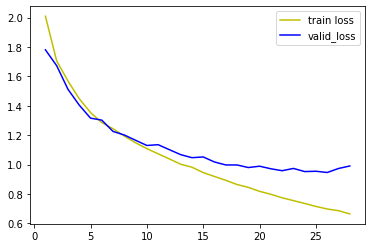

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.947305



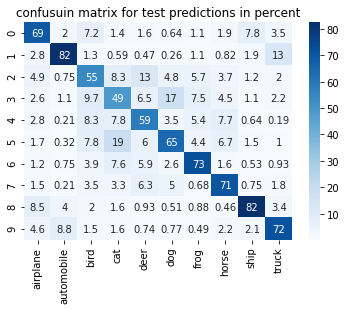

              precision    recall  f1-score   support

    airplane     0.6926    0.7300    0.7108      1000
  automobile     0.8187    0.7630    0.7899      1000
        bird     0.5480    0.5480    0.5480      1000
         cat     0.4912    0.5020    0.4965      1000
        deer     0.5875    0.6310    0.6085      1000
         dog     0.6474    0.5030    0.5661      1000
        frog     0.7276    0.7480    0.7377      1000
       horse     0.7053    0.7730    0.7376      1000
        ship     0.8248    0.7720    0.7975      1000
       truck     0.7169    0.7750    0.7448      1000

    accuracy                         0.6745     10000
   macro avg     0.6760    0.6745    0.6737     10000
weighted avg     0.6760    0.6745    0.6737     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_26

In [ ]:
model_name = 'ResNet10_26'
class ResNet10_26(nn.Module):
  def __init__(self):
    super(ResNet10_26,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_48 = torch.zeros(batch_size,48,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(x + identity)
    identity = x.clone() 
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_48],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores
    
model = ResNet10_26()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 2.00202 valid_loss: 1.77310
Validation loss decreased (inf --> 1.773101).  Saving model ...
[  2/100] train_loss: 1.65797 valid_loss: 1.56145
Validation loss decreased (1.773101 --> 1.561445).  Saving model ...
[  3/100] train_loss: 1.51407 valid_loss: 1.46900
Validation loss decreased (1.561445 --> 1.469000).  Saving model ...
[  4/100] train_loss: 1.44496 valid_loss: 1.41659
Validation loss decreased (1.469000 --> 1.416585).  Saving model ...
[  5/100] train_loss: 1.37746 valid_loss: 1.33531
Validation loss decreased (1.416585 --> 1.335311).  Saving model ...
[  6/100] train_loss: 1.29506 valid_loss: 1.29995
Validation loss decreased (1.335311 --> 1.299951).  Saving model ...
[  7/100] train_loss: 1.25158 valid_loss: 1.25661
Validation loss decreased (1.299951 --> 1.256609).  Saving model ...
[  8/100] train_loss: 1.21680 valid_loss: 1.22503
Validation loss decreased (1.256609 --> 1.225026).  Saving model ...
[  9/100] train_loss: 1.18956 valid_loss: 1.21429
Val

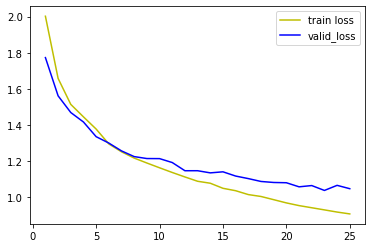

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 1.030060



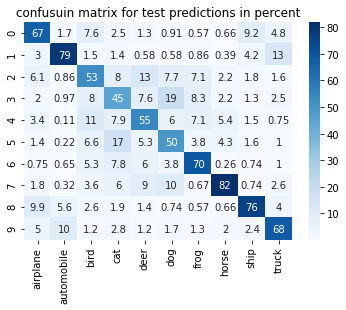

              precision    recall  f1-score   support

    airplane     0.6673    0.7140    0.6899      1000
  automobile     0.7946    0.7350    0.7636      1000
        bird     0.5250    0.4930    0.5085      1000
         cat     0.4484    0.4480    0.4482      1000
        deer     0.5467    0.5680    0.5571      1000
         dog     0.4950    0.5990    0.5421      1000
        frog     0.6959    0.7300    0.7125      1000
       horse     0.8187    0.6230    0.7076      1000
        ship     0.7646    0.7210    0.7422      1000
       truck     0.6845    0.7290    0.7061      1000

    accuracy                         0.6360     10000
   macro avg     0.6441    0.6360    0.6378     10000
weighted avg     0.6441    0.6360    0.6378     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_53

In [ ]:
model_name = 'ResNet10_53'
class ResNet10_53(nn.Module):
  def __init__(self):
    super(ResNet10_53,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(self.conv2_1(x)) #layer4 32*16*1
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv3_1(x)) #layer7 64*16    
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_53()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 2.00794 valid_loss: 1.79024
Validation loss decreased (inf --> 1.790243).  Saving model ...
[  2/100] train_loss: 1.70196 valid_loss: 1.60672
Validation loss decreased (1.790243 --> 1.606723).  Saving model ...
[  3/100] train_loss: 1.53815 valid_loss: 1.48794
Validation loss decreased (1.606723 --> 1.487942).  Saving model ...
[  4/100] train_loss: 1.43581 valid_loss: 1.38211
Validation loss decreased (1.487942 --> 1.382108).  Saving model ...
[  5/100] train_loss: 1.33813 valid_loss: 1.30645
Validation loss decreased (1.382108 --> 1.306451).  Saving model ...
[  6/100] train_loss: 1.27488 valid_loss: 1.25846
Validation loss decreased (1.306451 --> 1.258457).  Saving model ...
[  7/100] train_loss: 1.20796 valid_loss: 1.22911
Validation loss decreased (1.258457 --> 1.229111).  Saving model ...
[  8/100] train_loss: 1.15802 valid_loss: 1.15408
Validation loss decreased (1.229111 --> 1.154075).  Saving model ...
[  9/100] train_loss: 1.11371 valid_loss: 1.10839
Val

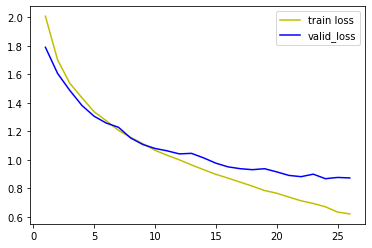

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 0.868180



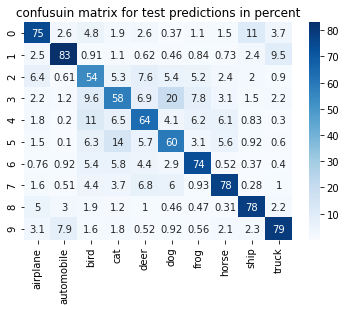

              precision    recall  f1-score   support

    airplane     0.7505    0.6920    0.7201      1000
  automobile     0.8299    0.8100    0.8198      1000
        bird     0.5395    0.6550    0.5917      1000
         cat     0.5817    0.4200    0.4878      1000
        deer     0.6383    0.6160    0.6270      1000
         dog     0.5963    0.6470    0.6206      1000
        frog     0.7376    0.7900    0.7629      1000
       horse     0.7760    0.7450    0.7602      1000
        ship     0.7837    0.8480    0.8146      1000
       truck     0.7926    0.7950    0.7938      1000

    accuracy                         0.7018     10000
   macro avg     0.7026    0.7018    0.6999     10000
weighted avg     0.7026    0.7018    0.6999     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# ResNet10_35

In [ ]:
model_name = 'ResNet10_35'
class ResNet10_35(nn.Module):
  def __init__(self):
    super(ResNet10_35,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    padding_zeros_16 = torch.zeros(batch_size,16,16,16).to(device)
    padding_zeros_32 = torch.zeros(batch_size,32,16,16).to(device)
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    identity = x.clone()
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 16*16*16
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(x + torch.cat([identity,padding_zeros_16],axis=1))
    identity = x.clone()
    x = F.relu(self.conv2_2(x)) #layer5 32*16*16
    x = F.relu(self.conv2_2(x)) #layer6 32*16*16
    x = F.relu(self.conv3_1(x)) #layer7 64*16    
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = F.relu(x + torch.cat([identity,padding_zeros_32],axis=1))
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = ResNet10_35()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, patience,
                                                        num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 2.00223 valid_loss: 1.80715
Validation loss decreased (inf --> 1.807148).  Saving model ...
[  2/100] train_loss: 1.70766 valid_loss: 1.65641
Validation loss decreased (1.807148 --> 1.656410).  Saving model ...
[  3/100] train_loss: 1.59006 valid_loss: 1.54672
Validation loss decreased (1.656410 --> 1.546723).  Saving model ...
[  4/100] train_loss: 1.49856 valid_loss: 1.49642
Validation loss decreased (1.546723 --> 1.496415).  Saving model ...
[  5/100] train_loss: 1.41330 valid_loss: 1.38789
Validation loss decreased (1.496415 --> 1.387893).  Saving model ...
[  6/100] train_loss: 1.32256 valid_loss: 1.29673
Validation loss decreased (1.387893 --> 1.296731).  Saving model ...
[  7/100] train_loss: 1.26923 valid_loss: 1.27958
Validation loss decreased (1.296731 --> 1.279577).  Saving model ...
[  8/100] train_loss: 1.22286 valid_loss: 1.21019
Validation loss decreased (1.279577 --> 1.210193).  Saving model ...
[  9/100] train_loss: 1.17919 valid_loss: 1.19483
Val

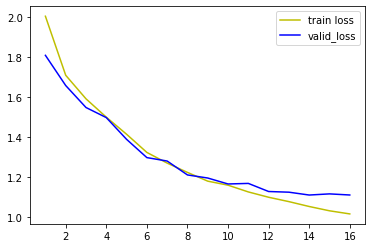

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 1.111935



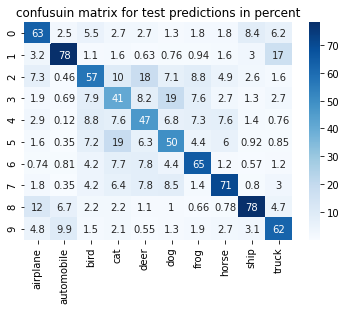

              precision    recall  f1-score   support

    airplane     0.6343    0.6870    0.6596      1000
  automobile     0.7809    0.6770    0.7252      1000
        bird     0.5735    0.3120    0.4041      1000
         cat     0.4103    0.4760    0.4407      1000
        deer     0.4655    0.5930    0.5215      1000
         dog     0.4967    0.5250    0.5105      1000
        frog     0.6526    0.6970    0.6741      1000
       horse     0.7073    0.6330    0.6681      1000
        ship     0.7793    0.6780    0.7251      1000
       truck     0.6244    0.7380    0.6764      1000

    accuracy                         0.6016     10000
   macro avg     0.6125    0.6016    0.6005     10000
weighted avg     0.6125    0.6016    0.6005     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# PlainNet10

In [ ]:
model_name = 'Plain10'
class Plain10(nn.Module):
  def __init__(self):
    super(Plain10,self).__init__()
    self.conv1_1 = nn.Conv2d(3, 16, 4, padding=1, stride=2, padding_mode='replicate')
    self.conv1_2 = nn.Conv2d(16, 16, 3, padding=1, padding_mode='replicate')
    self.conv2_1 = nn.Conv2d(16, 32, 3, padding=1, padding_mode='replicate')
    self.conv2_2 = nn.Conv2d(32, 32, 3, padding=1, padding_mode='replicate')
    self.conv3_1 = nn.Conv2d(32, 64, 3, padding=1, padding_mode='replicate')
    self.conv3_2 = nn.Conv2d(64, 64, 3, padding=1, padding_mode='replicate')
    self.avpool = nn.AvgPool2d(2,2)
    self.fc1 = nn.Linear(8*8*64,10)
  def forward(self, x):
    x = F.relu(self.conv1_1(x)) #layer1 16*16*16
    x = F.relu(self.conv1_2(x)) #layer2 
    x = F.relu(self.conv1_2(x)) #layer3 
    x = F.relu(self.conv2_1(x)) #layer4 32*16*16
    x = F.relu(self.conv2_2(x)) #layer5 
    x = F.relu(self.conv2_2(x)) #layer6 
    x = F.relu(self.conv3_1(x)) #layer7 64*16*16
    x = F.relu(self.conv3_2(x)) #layer8
    x = F.relu(self.conv3_2(x)) #layer9 
    x = self.avpool(x)
    x = x.view(-1,64*8*8)
    x = self.fc1(x)
    return x #10 class scores

model = Plain10()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)

start_time = time.time()
model, train_loss, valid_loss, iterations = train_model(model, batch_size, 5, num_epochs, model_name)
print("--- %s minuts ---" % ((time.time() - start_time)/60))

[  1/100] train_loss: 2.30288 valid_loss: 2.30267
Validation loss decreased (inf --> 2.302674).  Saving model ...
[  2/100] train_loss: 2.30283 valid_loss: 2.30261
Validation loss decreased (2.302674 --> 2.302613).  Saving model ...
[  3/100] train_loss: 2.30278 valid_loss: 2.30264
EarlyStopping counter: 1 out of 5
[  4/100] train_loss: 2.30278 valid_loss: 2.30265
EarlyStopping counter: 2 out of 5
[  5/100] train_loss: 2.30274 valid_loss: 2.30267
EarlyStopping counter: 3 out of 5
[  6/100] train_loss: 2.30275 valid_loss: 2.30264
EarlyStopping counter: 4 out of 5
[  7/100] train_loss: 2.30272 valid_loss: 2.30261
Validation loss decreased (2.302613 --> 2.302608).  Saving model ...
[  8/100] train_loss: 2.30273 valid_loss: 2.30265
EarlyStopping counter: 1 out of 5
[  9/100] train_loss: 2.30271 valid_loss: 2.30261
EarlyStopping counter: 2 out of 5
[ 10/100] train_loss: 2.30269 valid_loss: 2.30257
Validation loss decreased (2.302608 --> 2.302572).  Saving model ...
[ 11/100] train_loss: 2.3

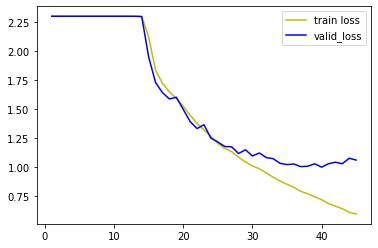

In [ ]:
plot_losses(train_loss, valid_loss, iterations)
train_loss_dict[model_name] = train_loss
valid_loss_dict[model_name] = valid_loss

Test Loss: 1.014295



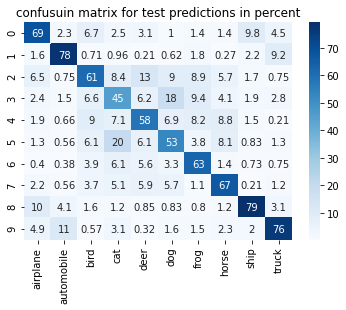

              precision    recall  f1-score   support

    airplane     0.6892    0.6940    0.6916      1000
  automobile     0.7784    0.8290    0.8029      1000
        bird     0.6120    0.4290    0.5044      1000
         cat     0.4546    0.4760    0.4651      1000
        deer     0.5846    0.5530    0.5683      1000
         dog     0.5312    0.5110    0.5209      1000
        frog     0.6308    0.7860    0.6999      1000
       horse     0.6681    0.7550    0.7089      1000
        ship     0.7931    0.7630    0.7778      1000
       truck     0.7623    0.7120    0.7363      1000

    accuracy                         0.6508     10000
   macro avg     0.6504    0.6508    0.6476     10000
weighted avg     0.6504    0.6508    0.6476     10000



In [ ]:
test_accuracy = eval_model(model)
test_accuracy_dict[model_name] = test_accuracy

# Models comparison

In [3]:
path = "/content/gdrive/My Drive/ResNet10_momentum0.9_patience2avpool22/" 

# pickle.dump(train_loss_dict, open(path+"train_loss_dict_10", 'wb'))
# pickle.dump(valid_loss_dict, open(path+"valid_loss_dict_10", 'wb'))
# pickle.dump(test_accuracy_dict, open(path+"test_accuracy_dict_10", 'wb'))

train_loss_dict = pickle.load(open(path+"train_loss_dict_10", 'rb'))
valid_loss_dict = pickle.load(open(path+"valid_loss_dict_10", 'rb'))
test_accuracy_dict = pickle.load(open(path+"test_accuracy_dict_10", 'rb'))

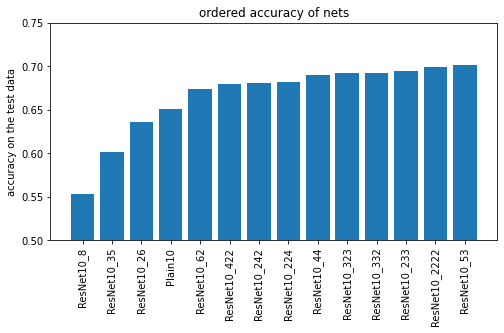

In [103]:
ordered_dict_accuracy = {k: v for k, v in sorted(test_accuracy_dict.items(), key=lambda item: item[1])}
ordered_nets = list(ordered_dict_accuracy.keys())
fig, ax = plt.subplots(figsize=(8,4))
ax.bar(ordered_nets, height=ordered_dict_accuracy.values())
ax.set_ylim([0.5,0.75])
plt.xticks(rotation=90)
plt.ylabel('accuracy on the test data')
plt.title('ordered accuracy of nets')
plt.show()

In [104]:
nets = train_loss_dict.keys()

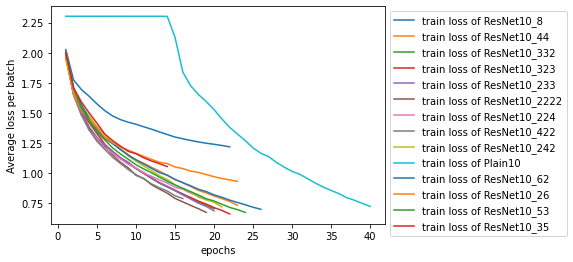

In [105]:
E = []
for n in nets:
  if n == 'Plain10':
    e = len(train_loss_dict[n])-5
    plt.plot(range(1,e+1),train_loss_dict[n][:-5], label = 'train loss of '+n)
  else:
    e = len(train_loss_dict[n])-2
    plt.plot(range(1,e+1),train_loss_dict[n][:-2], label = 'train loss of '+n)
  E.append(e)
  
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.xlabel('epochs')
plt.ylabel('Average loss per batch')
plt.show()

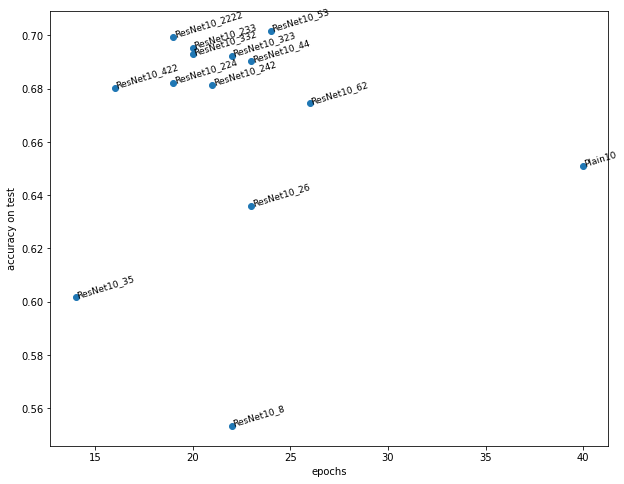

In [106]:
test_accuracy_list = [i for i in test_accuracy_dict.values()]
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(E, test_accuracy_list)
for i, txt in enumerate(nets):
    ax.annotate(txt, (E[i],test_accuracy_list[i]),rotation=17,size=9)
plt.xlabel('epochs')
plt.ylabel('accuracy on test')
plt.show()

The plain model converges much slower and performance is worse than of some ResNets. Most ResNets containing only short (2,3,4) blocks perform better, although ResNet10_53 has the best accuracy, ResNet with one big block of length 8 has the worst performance on test data.

Architecture without average poling was tried, performance on test data for each NN was from 1% to 6% less than with average pooling.